In [1]:
# https://www.dacon.io/competitions/official/235736/codeshare/2844?page=undefined&dtype=recent&ptype&fType
# https://www.kaggle.com/code/kensinnoh/energy-usage-prediction

In [2]:
# 1) 우선 필요한 변수를 생성하고 결측치를 채우는 '전처리'를 진행하고, 
# 2) '건물별 전력사용량에 대한 분석'과 이를 바탕으로 '유사한 건물들로 군집화'를 하여 이들의 '패턴을 확인'
# 3) LSTM와 XGBoost를 활용하여 건물별 전력사용량을 예측

In [1]:
import pandas as pd
import numpy as np
import math

# Visualizing
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Malgun Gothic'; plt.rcParams['axes.unicode_minus']=False;
import seaborn as sns; #sns.set_style('whitegrid')

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss,ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Clustering (+알파)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from minisom import MiniSom

# Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# System
from ipywidgets import interact
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Custom Loss Function
import keras.backend as K

def SMAPE(true,predicted):
    epsilon=0.1
    summ=K.maximum(K.abs(true)+K.abs(predicted)+epsilon,0.5+epsilon)
    smape=K.abs(predicted-true)/summ*2.0
    return smape

In [3]:
train=pd.read_csv('C:\\Users\\pc\\Desktop\\energy\\train.csv',encoding='euc-kr',parse_dates=['date_time'])
test=pd.read_csv('C:\\Users\\pc\\Desktop\\energy\\test.csv',encoding='euc-kr',parse_dates=['date_time'])
submission=pd.read_csv('C:\\Users\\pc\\Desktop\\energy\\sample_submission.csv',encoding='euc-kr')

In [4]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [5]:
### 1. 전처리 ###

In [6]:
# 1) 시간 관련 변수 생성
# 먼저 train 데이터와 test 데이터에 월,일,시간,요일,주말여부에 해당하는 시간 변수를 생성하였다.

# 요일
def weekday(x):
    if x.dayofweek==6:
        return '일'
    elif x.dayofweek==0:
        return '월'
    elif x.dayofweek==1:
        return '화'
    elif x.dayofweek==2:
        return '수'
    elif x.dayofweek==3:
        return '목'
    elif x.dayofweek==4:
        return '금'
    else:
        return '토'
    
# 주말 여부
def weekend(x):
    if x.dayofweek in [5,6]:
        return 1
    else:
        return 0

In [7]:
train['month']=train['date_time'].dt.month
train['day']=train['date_time'].dt.day
train['hour']=train['date_time'].dt.hour
train['weekday']=train['date_time'].apply(weekday)
train['weekend']=train['date_time'].apply(weekend)

In [8]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekday,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,월,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,월,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,월,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,월,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,월,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19,월,0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20,월,0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21,월,0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22,월,0


In [9]:
# 2) test 결측치 채우기

In [10]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21:00:00,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print('\033[1m<test함수 변수별 결측값 수> \033[0m\n',test.isna().sum())

<test함수 변수별 결측값 수> 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64


In [12]:
## 결측치 채우기 : 건물 변수 ##
# 먼저 건물 변수인 '비전기냉방설비운영','태양광보유'의 결측치를 채워주겠다.
# 건물정보는 건물이 동일하면 모두 같은 값을 가지고, 
# test 데이터의 건물 종류는 train 데이터의 건물 종류와 동일하므로,
# train 데이터의 건물 변수 값을 이용하여 결측값을 채워준다.

building_info=train[['num','비전기냉방설비운영','태양광보유']].drop_duplicates()

test.drop(columns=['비전기냉방설비운영','태양광보유'],inplace=True)
test=pd.merge(test,building_info,on='num')

## 결측치 채우기 : 일조 ##
train['일조(hr)'].value_counts()
# train 데이터의 일조를 확인하면 discrete한 분포를 지님을 확인할 수 있다.
# 따라서 가장 최근에 기록된 일조값을 가져오는 형태로 결측치를 채워준다.
test['일조(hr)']=test['일조(hr, 3시간)'].interpolate(method='pad')

In [13]:
## 결측치 채우기 : 기온, 풍속, 습도, 강수량 ##
# 기온, 풍속, 습도, 강수량은 'pad','linear','quadratic','cubic' 방법 중 
# train 데이터에서 가장 성능이 뛰어난 보간법으로 결측치를 채워준다.

# 우선 train 데이터에 임의로 결측치를 생성한다.
train_=train.copy()

def make_train_nan(col,n):
    new_list=[]
    for idx,temp in enumerate(train_[col]):
        if idx%n==0:
            new_list.append(temp)
        else:
            new_list.append(np.nan)
    train_['{}'.format(col+'_nan')]=new_list

In [14]:
make_train_nan('기온(°C)',3)
make_train_nan('풍속(m/s)',3)
make_train_nan('습도(%)',3)
make_train_nan('강수량(mm)',6)

print(train_.iloc[:.-4:].isnull().sum())

In [15]:
print(train_.iloc[:,-4:].isnull().sum())

기온(°C)_nan      81600
풍속(m/s)_nan     81600
습도(%)_nan       81600
강수량(mm)_nan    102000
dtype: int64


In [16]:
# 결측지가 잘 생성됨을 확인할 수 있다.
# 각 변수에 대해 4가지의 보간법을 시행한 후 가장 오차가 적은 보간법으로 결측치를 채워준다.

def compare_interpolate_methods(col,methods,metric):
    error_dict=dict()
    for method in methods:
        fillna=train_['{}'.format(col+'_nan')].interpolate(method=method)
        if fillna.isna().sum()!=0:
            fillna=fillna.interpolate(method='linear')
        error=metric(train_['{}'.format(col)],fillna)
        error_dict['{}'.format(method)]=error
    
    return error_dict

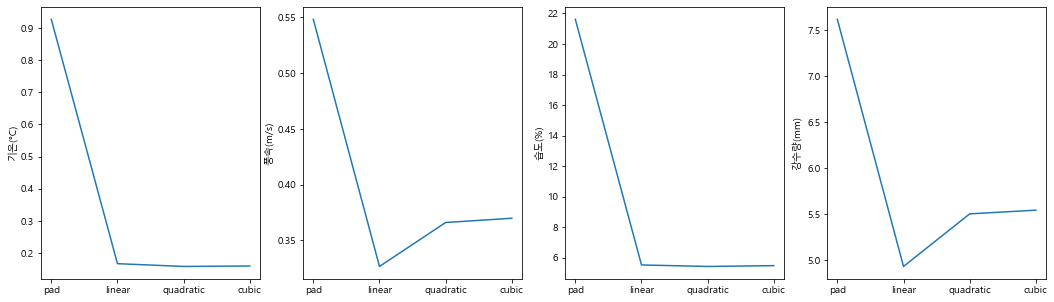

In [17]:
all_cols_error_dict=dict()
for col in ['기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)']:
    methods=['pad','linear','quadratic','cubic']
    error_dict=compare_interpolate_methods(col,methods,mean_squared_error)
    all_cols_error_dict['{}'.format(col)]=error_dict
    
all_cols_error_df=pd.DataFrame(all_cols_error_dict)

fig,axes=plt.subplots(1,4,figsize=(18,5),sharey=False)
for i in range(len(all_cols_error_df.columns)):
    sns.lineplot(ax=axes[i],data=all_cols_error_df.iloc[:,i].transpose())

In [18]:
# 기온 결측치 채우기
test['기온(°C)']=test['기온(°C)'].interpolate(method='quadratic')
# 마지막 na 채우기
test['기온(°C)']=test['기온(°C)'].interpolate(method='linear')

# 풍속 결측치 채우기
test['풍속(m/s)']=test['풍속(m/s)'].interpolate(method='linear')

# 습도 결측치 채우기
test['습도(%)']=test['습도(%)'].interpolate(method='quadratic')
# 마지막 na 채우기
test['습도(%)']=test['습도(%)'].interpolate(method='linear')

# 강수량 결측치 채우기
test['강수량(mm)']=test['강수량(mm, 6시간)'].interpolate(method='linear')

In [19]:
### 3) 불쾌지수 생성 ###
# 불쾌지수 = 불쾌지수=1.8T-0.55(1-RH)(1.8T-26)+32불쾌지수=1.8T−0.55(1−RH)(1.8T−26)+32

# 불쾌지수란 기온과 습도의 조합으로 사람이 느끼는 온도를 표현한 것으로 온습도지수(THI)라고도 한다.
# 불쾌지수는 여름철 실내의 무더위의 기준르오서만 사용되고 있을 뿐, 복사나 바람의 조건은 포함되어 있지 않다. 
# 때문에 그 적정한 사용에는 한계가 있다는 점에 유의해야 한다.
# 해당 데이터가 여름철 데이터인 만큼 전력사용량과 관련이 있을 것이라고 판단했다.

# 마지막으로 날씨 변수를 이용하여 쾌적함의 척도로써 
# 여름철 에어컨 사용 등 전력사용량에 영향을 미칠 것으로 예상되는 불쾌지수를 추가했다.
train['불쾌지수']=1.8*train['기온(°C)']-0.55*(1-(train['습도(%)']/100))*(1.8*train['기온(°C)']-26)+32
test['불쾌지수']=1.8*test['기온(°C)']-0.55*(1-(test['습도(%)']/100))*(1.8*test['기온(°C)']-26)+32

In [20]:
### 4) 체감온도 생성 ###
# 체감온도=13.12+0.6125T-13.947V^(0.16)+0.486TV^(0.16)체감온도
# 체감온도는 불쾌지수에서 포함하지 않은 바람의 조건을 포함하고 있어 보완해주는 변수라고 판단했다.
train['체감온도']=13.12+0.6215*train['기온(°C)']-13.947*train['풍속(m/s)']**0.16+0.486*train['기온(°C)']*train['풍속(m/s)']**0.16
test['체감온도']=13.12+0.6215*test['기온(°C)']-13.947*test['풍속(m/s)']**0.16+0.486*test['기온(°C)']*test['풍속(m/s)']**0.16

In [22]:
### 2. Exploratory Data Analysis ###
# 저희는 건물별 전력사용량의 예측 및 분석을 하고자 건물 관련 정보를 적극 이용하고자 했다.
# 하지만 주어진 데이터에 주어진 건물 관련 자료는 건물 번호, 비전기냉방설비운영, 태양광보유 3가지의 변수로 
# 제한적인 정보 뿐이라, 건물 관련 더 자세한 정보가 있으면 좋을 것 같다는 판단 하에, 용도에 따른 건축물 분류를 적용했다.

# 테이터 설명에서 주어진 건물 관련 용도는 아파트, 병원, 팍교 등 7가지 용도의 건물이라는 사실을 바탕으로 
# 나머지 건물의 용도를 추측했다. 보편적으로 사용되는 해당 기준을 적용하여 다양한 기준에 따라 건물의 용도를 추측하고,
# 그 결과 용도에 맞는 사업 및 전력사용량 절약 방법에 대해 제시할 수 있을 것이라고 생각했다.

# 이 때 사용된 기준은 IBC(International Building Code)로 건축물을 용도에 딸 10가지로 구분한 볍규이다.

<AxesSubplot:xlabel='전력사용량(kWh)', ylabel='Count'>

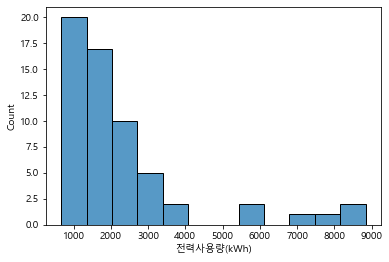

In [23]:
## 1) 전력사용량 기본 EDA
# 건물들의 평균 전력사용량
sns.histplot(train.groupby('num')['전력사용량(kWh)'].mean())

# 한 시간에 평균 1000kWh를 쓰는 건물부터 9000kWh를 쓰는 건물까지 
# 건물마다 전력사용량의 총량이 매우 다양하다는 것을 확인할 수 있다.

In [24]:
## 건물 변수와 전력사용량의 관계
train.groupby(['비전기냉방설비운영','태양광보유'])['전력사용량(kWh)'].mean()

비전기냉방설비운영  태양광보유
0.0        0.0      2077.030506
           1.0      1582.298192
1.0        0.0      2101.993590
           1.0      2949.726621
Name: 전력사용량(kWh), dtype: float64

In [25]:
# 일반적으로 비전기냉방설비를 운영하고 태양광을 보유하면 전력사용량이 더 적을 것으로 예상할 수 있다.
# 건물별 거주인구, 유동인구 및 건물면적 등의 정보를 모르기 때문에 주어진 건물 변수와 전력사용량의 관계를
# 정확히 알 수는 없지만, 예상과 달리 
# 비전기냉방설비운영 여부, 태양광보유 여부가 건물의 전력 사용량을 낮춰주진 않는다는 것을 확인할 수 있다.

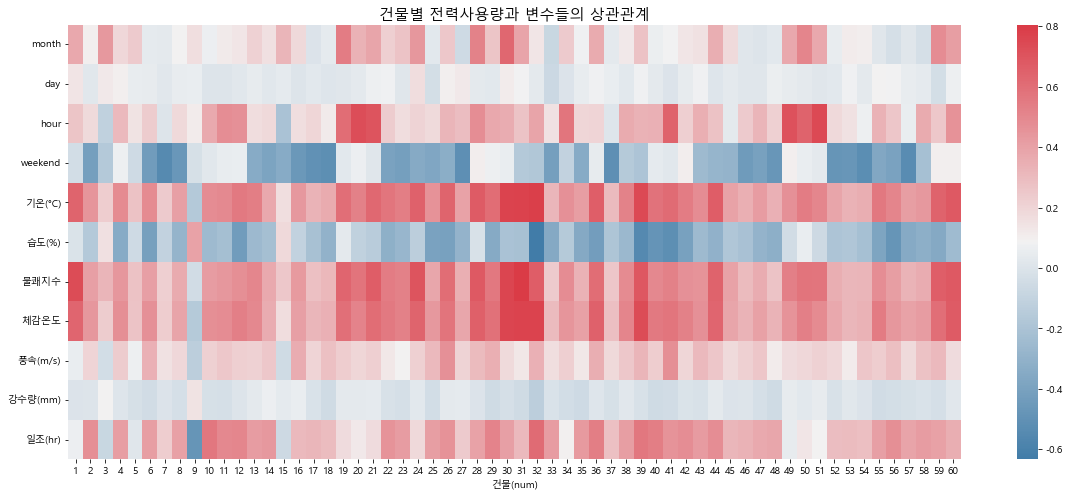

In [26]:
# 건물별 전력사용량과 다른 변수들의 상관관계

corr=[]
for num in range(1,61):
    df=train[train.num==num]
    num_corr=df.corr()['전력사용량(kWh)']
    num_corr=num_corr.drop(['num','비전기냉방설비운영','태양광보유','전력사용량(kWh)'])
    corr.append(num_corr)
corr_df=pd.concat(corr,axis=1).T
corr_df.index=list(range(1,61))

# 시각화
f,ax=plt.subplots(figsize=(20,8))
plt.title("건물별 전력사용량과 변수들의 상관관계",fontsize=15)
sns.heatmap(corr_df.T,cmap=sns.diverging_palette(240,10,as_cmap=True),ax=ax)
plt.xlabel('건물(num)')
plt.show()

In [27]:
## 건물별로 전력사용량과의 각 변수들의 상관계수가 다름을 알 수 있다.
# 예를 들어, 
# - 건물 1 : 기온과 강한 양의 상관관계를 가지고,
# - 건물 9 : 기온과는 상관관계가 거의 없고, 일조와 음의 상관관계를 가진다.

# 이후 전력사용량을 모델링할 때 이를 기반으로 건물별로 다른 변수를 사용하도록 하였다.

## 추가변수와 각 건물의 전력 사용량 평균 시각화
# 위에서 기상청에서 제공하는 생활기상지수 중 불쾌지수와 체감온도를 새로운 변수로 생성했다. 
# 이에 따라 기상청에서 제공하는 기준에 따라 불쾌지수와 체감온도를 카테고리화 했다.

In [28]:
# <불쾌지수> #
# x>=80 : 매우높음
# 75<= x <80 : 높음
# 68<= x <75 : 보통
# x <68 : 낮음

print(train['불쾌지수'].min())
print(train['불쾌지수'].max())

52.344210000000004
86.66179


In [29]:
train['불쾌지수_c']=pd.cut(train.불쾌지수, bins=[50,68,75,80,90],labels=['낮음','보통','높음','매우높음'])

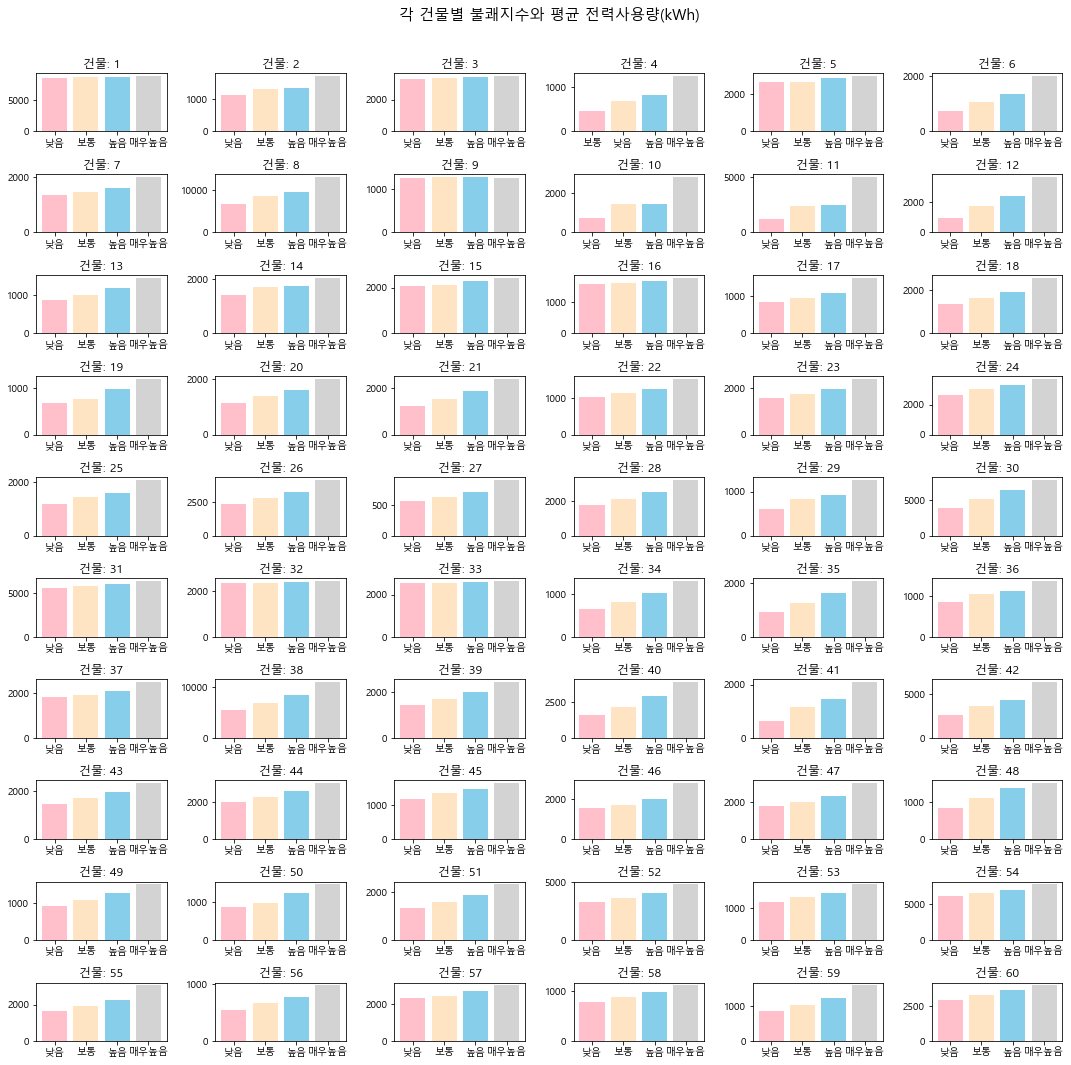

In [30]:
# 불쾌지수
fig=plt.figure(figsize=(15,15))
plt.title("각 건물별 불쾌지수와 평균 전력사용량(kWh)",fontsize=15,y=1.05)
plt.axis('off')

colors=['pink','bisque','skyblue','lightgrey']

for num in range(1,61):
    df=train[train.num==num]
    df_counts=df.groupby('불쾌지수_c')['전력사용량(kWh)'].mean()
    ax=fig.add_subplot(10,6,num)
    ax.bar(df['불쾌지수_c'].unique(),df_counts,color=colors)
    ax.set_title(f'건물: {num}')
    
plt.tight_layout()
plt.show()

In [31]:
# 건물별 불쾌지수와 평균 전력사용량을 시각화한 결과이다.
# 불쾌지수와 관련없이 전력사용량의 평균이 비슷한 케이스와 
# 불쾌지수가 높을수록 전력사용량이 늘어나는 두 가지의 케이스로 볼 수 있다.

# 1. 불쾌지수의 수준과 전력사용량의 차이가 거의 없는 건물
# - 사람들의 사용보다 건물 자체의 이용이 주가 되는 용도의 건물일 것이라고 판단
# 2. 불쾌지수의 수준이 높아질수록 전력사용량이 증가하는 건물
# - 사람들이 직접 이용하는 건물일 확률이 높다고 판단

In [32]:
# <체감 온도> #
# t >=31: 매우위험
# 28<= t <31 : 위험
# 25<= t <28 : 경고
# 21<= t <25 : 주의
# t <21 : 관심

print(train['체감온도'].min())
print(train['체감온도'].max())

11.940652931164212
39.70264167119042


In [33]:
train.loc[train['체감온도']>=31,'체감온도_b']='매우\위험'
train.loc[(train['체감온도']>=28)&(train['체감온도']<31),'체감온도_b']='위험'
train.loc[(train['체감온도']>=25)&(train['체감온도']<28),'체감온도_b']='경고'
train.loc[(train['체감온도']>=21)&(train['체감온도']<25),'체감온도_b']='주의'
train.loc[train['체감온도']<21,'체감온도_b']='관심'

In [34]:
train['체감온도_b'].unique()

array(['관심', '주의', '경고', '위험', '매우\\위험'], dtype=object)

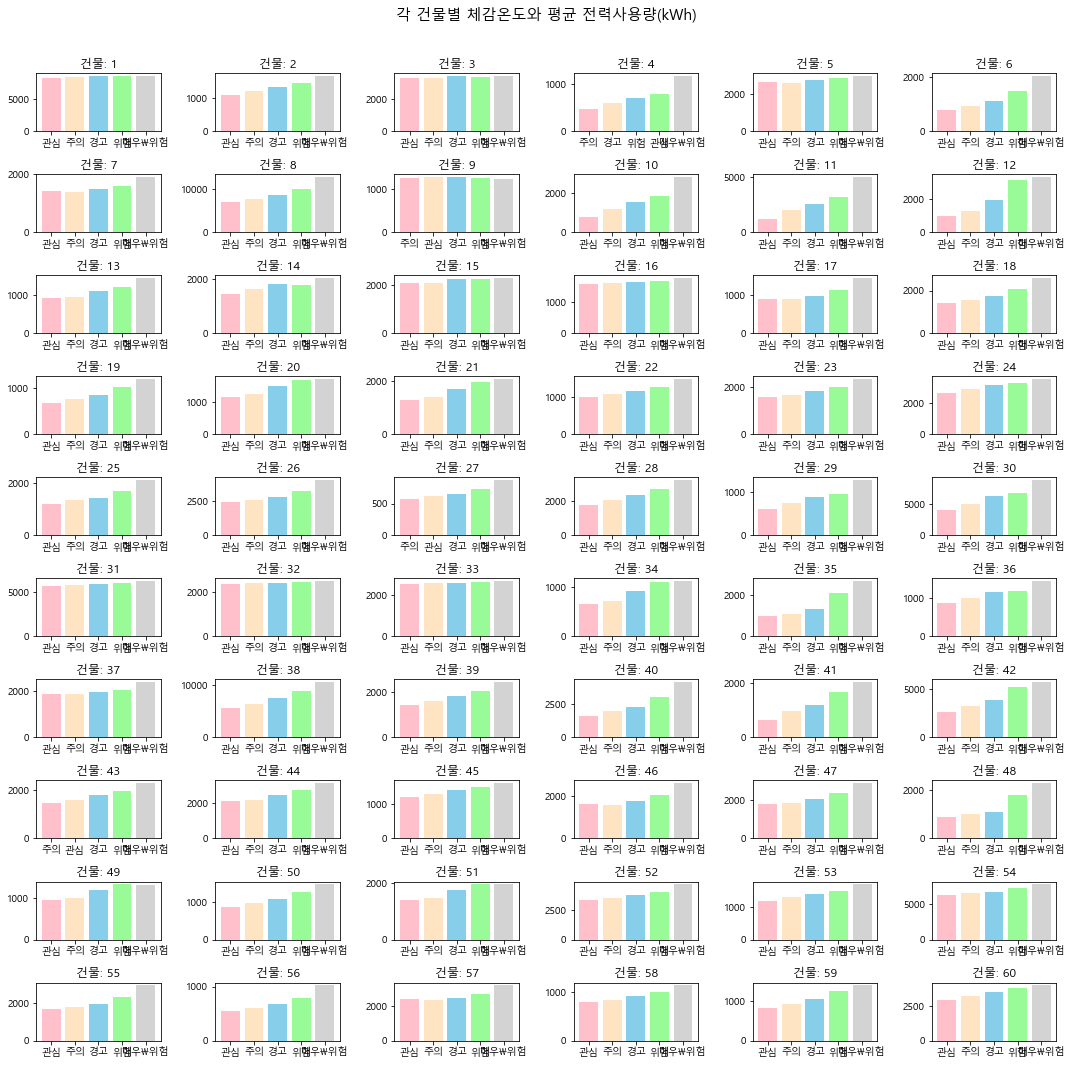

In [35]:
# 불쾌지수
fig=plt.figure(figsize=(15,15))
plt.title("각 건물별 체감온도와 평균 전력사용량(kWh)",fontsize=15,y=1.05)
plt.axis('off')

colors=['pink','bisque','skyblue','palegreen','lightgrey']
sensible_temp=train['체감온도_b'].unique()

for num in range(1,61):
    df=train[train.num==num]
    df_counts=df.groupby('체감온도_b')['전력사용량(kWh)'].mean()
    df_counts=df_counts.reindex(sensible_temp)
    ax=fig.add_subplot(10,6,num)
    ax.bar(df['체감온도_b'].unique(),df_counts,color=colors)
    ax.set_title(f'건물: {num}')
    
plt.tight_layout()
plt.show()

In [36]:
train['체감온도_b'].value_counts()

주의       38824
경고       36151
위험       23044
매우\위험    12344
관심       12037
Name: 체감온도_b, dtype: int64

In [37]:
# 건물별 체감온도와 평균 전력사용량을 시각화한 결과이다.
# 체감온도와 관련없이 전력사용량의 평균이 비슷한 케이스와 체감온도가 '경고'일 때
# 가장 높은 건물들 두 가지의 케이스로 나누어 볼 수 있다.

# 1. 체감온도의 수준과 전력사용량의 차이가 거의 없는 건물
# - 예시 : 건물 1,3,5,9,15,16,31,32,33
# - 예측 : 공장, 저장(창고) 등

# 2. 체감온도의 수준이 높아질수록 전력사용량이 증가하는 건물
# - 예시 : 건물 2,4,6,7,8,10,11,12,13,14,17-30, 34-60
# - 예측 : 주거, 집회, 사업 등

# 체감온도와 평균 전력사용량의 시각화를 통해 나눈 두 분류가 위 불쾌지수를 통해 나눈 분류와
# 동일한 결과를 나타냄을 알 수 있다.

# 사람의 이용인지, 건물 자체의 사용인지에 따라 상이한 전력사용량 및 비용 절약 방법을 추천할 수 있다.

In [1]:
### 2) 시계열 분석 ###
# 건물별로 시계열 분포가 다르므로 대표로 2개의 건물(건물 4, 건물 9)에 대해 시계열 분석을 하여
# 어떤 시계열적 특징이 있는지 확인해보았다.

## 시계열 분해
# 우선 시계열 분해를 토애 건물별 전력사용랴응 추세, 계절성, 잔차로 분해하였다.

def vis_time_series_decompose(num):
    df=train[train.num==num]
    df.index=df.date_time
    
    res=sm.tsa.seasonal_decompose(df['전력사용량(kWh)'],model='additive')
    
    fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(20,12))
    res.observed.plot(ax=ax1,title='Observed')
    res.trend.plot(ax=ax2,title='Trend')
    res.resid.plot(ax=ax3,title='Residual')
    res.seasonal.plot(ax=ax4,title='Seasonal')
    plt.tight_layout()
    plt.show()

In [ ]:
## 건물 4
vis_time_series_decompose(num=4)

In [ ]:
## 건물 9
vis_time_series_decompse(num=9)

In [ ]:
## 건물 4
df=train[train.num==4]
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(10,6))
plot_acf(df['전력사용량(kWh)'],lags=50,ax=ax1)
plot_pacf(df['전력사용량(kWh)'],lags=50,ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
## 건물 9
df=train[train.num==9]
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize(10,6))
plot_acf(df['전력사용량(kWh)'],lags=50,ax=ax1)
plot_pacf(df['전력사용량(kWh)'],lags=50,ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
# PACF를 봤을 대 두 건물모두 전력사용량은 
# 1시간, 2시간전과 크게 관계가 있고, 약 24시간 전의 전력사용량에도 약간의 영향을 받음을 확인할 수 있다.

In [ ]:
## 3) 각 건물의 시간에 따른 평균 전력사용량 시가화
# 시간별 평균 
fig=plt.figure(figsize=(15,15))
plt.title("각 건물의 시간별 평균 전력사용량(kWh)",fontsize=15,y=1.05)
plt.axis('off')

for num in range(1,61):
    df=train[train.num==num]
    ax=fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(), df.groupby('hour')['전력사용량(kWh)'].mean())
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
plt.tight_layout()
plt.show()

In [1]:
# 건물들은 하루동안 시간별로 가각 다르지만 또 비슷한 전력 사용 패턴을 보인다. 
# 눈에 띄는 패터넹 따라 건물들을 나눠 분석해보자.

# 1. 6시에 전력사용량이 증가하여 9시~18시까지 전력사요얄잉 많은 건물
# 예시 : 2,4,6,8 등
# 용도 추측 : 상가, 사무실이 많은 회사 건물

# 2. 1번 패턴과 비슷하나 12시쯤에 전력이 약간 줄어드는 건물
# 예시 : 6,8,13,14 등
# 용도 추측 : 점심시간을 갖는 회사가 모인 건물

# 3. 1번 패턴과 비슷하나 자정쯤에 전력량이 상승하는 건물
# 예시 : 7,18,23,42 등
# 용도 추측 : 새벽에 서버를 돌리는 회사가 있는 건물

# 4. 6시부터 상승하여 16시까지 비슷하다가 이후 20시쯤 피크를 찍는 건물
# 예시 : 19, 20, 21, 49 등
# 용도 추측 : 학원이 많은 건물, 24시간 페가 있는 건물

# 5. 저녁~새벽에 전력사용량이 많은 건물
# 예시 : 9 등
# 용도 추측 : 저녁에 영업하는 주점 등이 있는 상가 건물일 가능성 높음

# 이외에도 건물3의 경우 8시, 16시쯤 피크를 찍는 형태를 보이는 등의 패턴을 보인다.

In [ ]:
## 요일별 평균 전력사용량

fig=plt.figure(figsize=(15,15))
plt.title("각 건물의 요일별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

weekday=['월','화','수','목','금','토','일']
colors=['skyblue','skyblue','skyblue','skyblue','skyblue','pink','pink']

for num in range(1,61):
    df=train[train.num==num]
    df_counts=df.groupby('weekday')['전력사용량(kWh)'].mean()
    df_counts=df_countsreindex(weekday)
    ax=fig.add_subplot(10,6,num)
    ax.bar(df['weekday'].unique(),df_counts,color=colors)
    ax.set_title(f'건물: {num}')
plt.tight_layout()
plt.show()

In [ ]:
# 일주일동안의 전력사용량을 요일별로 보면 크게 3가지 패턴으로 나뉜다.
# 각 패턴에 따라 건물들을 나눠 분석해보았다.

# 1. 주말에 사용량이 감소하는 건물
# 예시 : 2,6,7 등 다수
# 용도 추측 : 사무실이 많은 회사 건물, 학교

# 2. 주말에 사용량이 약간 증가하는 건물
# 예시 : 11, 12 등
# 용도 추측 : 주거용 건물

# 3. 요일 상관없이 사용량이 일정한 건물
# 예시 : 1, 9
# 용도 추측 : 대학병원

In [ ]:
## 시간+요일별 평균 전력사용량
fig=plt.figure(figsize=(15,15))
plt.title("각 건물의 시간에 따른 주말여부 평균 전력사용량(kWh)",fontsize=15,y=1.05)
plt.axis('off')

for num in range(1,61):
    df=train[train.num==num]
    ax=fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(),df[df.weekend==0].groupby('hour')['전력사용량(kWh)'].mean(),label='평일')
    ax.plot(df['hour'].unique(),df[df.weekend==1].groupby('hour')['전력사용량(kWh)'].mean(),label='주말')
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])     
    lines,labels=fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines,labels,loc=1,prop={'size':12})
    plt.tight_layout()
    plt.show()

In [ ]:
# 마지막으로 평일과 주말을 나눠 하루동안의 전력사용량을 시각화하였다.
# 마찬가지로 패턴에 따라 건물들을 나눠보았다.

# 1. 평일과 주말의 패턴이 비슷한 건물
# - 예시 : 4,9,10 등

# 2. 평일과 주말의 낮시간대의 사용량이 차이나는 건물
# - 예시 : 2,6,7 등

# 3. 평일과 주말의 패턴이 반대인 건물
# - 예시 : 27

# 건물마다 시간에 따른 패턴이 다르지만 일정한 기준에 의해 묶을 수 있을 것으로 보인다.
# 따라서 군집화를 통해 비슷한 패턴을 가진 건물끼리 묶어보도록 하였다.

In [ ]:
### 군집화 ###
## Clustering(군집화) : 현실세계의 데이터는 항상 label이 주어지는 것은 아니다.
# 이러한 unlabeled 데이터에 숨겨진 패턴을 찾아내고 구조화하는 머신러닝 기법을 비지도 학습이라고 한다.
# Clustering은 가장 널리 알려진 비지도 학습 중 한 가지 기법으로, 비슷한 유형의 데이터를 그룹화함으로써 
# unlabeled 데이터에 숨겨진 구조를 파악한다.

## K-Means Clustering : K-Means 알고리즘은 가장 유명한 클러스터링 알고리즘이다.
# 'K'는 주어진 데이터로부터 그룹화 할 그룹, 즉 클러스터의 수를 말한다.
# "Means"는 각 클러스터의 중심과 데이터들의 평균 거리를 의미한다. 
# 이때 클러스터의 중심을 centroids라고 한다.
# [출처] https://eunsukimme.github.io/ml/2019/12/16/K-Means/

In [ ]:
## K-Means와 SOM의 두 가지 알고리즘을 사용하여 건물을 군집화하였다.

## 시계열 군집화용 DataFrame을 생성하는 함수(row->num, col->date_time)
def cluster_df(scaler=MinMaxScaler()):
    train_=train.copy()
    train_ts=train_.pivot_table(values='전력사용량(kWh)',index=train_.num,columns='date_time', aggfunc='first')
    
    if scaler:
        train_ts_T=scaler.fit_transform(trian_ts.T)
        train_ts=pd.DataFrame(train_st_T.T,index=train_ts.index, columns=train_ts.columns)
        
    return train_ts

In [ ]:
## SOM 알고리즘 결과를 정리해주는 DataFrame을 생성하는 함수
## SOM (Self-Organizing Map, SOM) : 차원축소(dimensionality reduction)와 군집화(clustering)을 동시에 수행하는 기법

# 그림에서 연두색 25개의 점은 고차원의 원데이터공간에 대응되는 격자벡터이다.
# 처음에는 그 위치를 랜덤으로 초기화한다. 이후 학습데이터 x(검정색 점)를 하나씩 추가해가며 
# 격자벡터의 위치를 x의 위치와 비슷해지도록 업데이트한다.(instance-based learning)
# [출처] https://ratsgo.github.io/machine%20learning/2017/05/01/SOM/
def make_som_df(X):
    win_map=som.win_map(X)
    som_result=[]
    for i in range(60):
        som_result.append([i+1,som.winner(X[i])])
    som_df=pd.DataFrame(som_result, columns=['num','cluster'])
    return som_df

In [ ]:
## 여러 n_cluster에 대해 TimeSeriesKmenas를 시행하고 이를 시각화하는 함수
def visualize_n_cluster(train_ts,n_lists=[3,4,5,6], metric='dtw',seed=2021,vis=True):
    
    if vis:
        ifg=plt.figure(figsize=(20,5))
        plt.title("군집 개수별 건물수 분포",fontsize=15,y=1.2)
        plt.axis('off')
        
    for idx, n in enumerate(n_lists):
        ts_kmeans=TimeSeriesKMeans(n_clusters=n,metric=metric, random_state=seed)
        train_ts['cluster(n={})'.format(n)]=ts.kemans.fit_predict(train_ts)
        score=round(silhouette_score(train_ts,train_ts['cluster(n={})'.format(n)], metric='euclidean'),3)
        
        vc=train_ts['cluster(n={})'.format(n)].value_counts()
        
        if vis:
            ax=fig.add_subplot(1,len(n_lists),idx+1)
            sns.barplot(x=vc.index,y=vc,palette='Pastel1')
            ax.set(title='n_cluster={0}\nscore:{1}'.format(n,score))
    if vis:
        plt.tight_layout()
        plt.show()
        
    return train_ts

In [ ]:
# 1) Time-Series KMeans
# 첫 번째로 이 알고리즘을 이용하여 전력사용량에 따라 건물을 군집화하였다.
# 이 때, 전력사용량을 StandardScaler를이용하여 표준화하여 
# 건물별 전력의 절대적 사용량이 아닌 사용 패턴을 사용하여 군집화하도록 하엿다.

# 또한 각 관측치간의 거리를 계산할 때는 euclidean 거리를 사용하였다.

# 시계열 데이터에서는 시간대가 다르더라도 계산할 수 있다는 장점을 지닌 
#DTW(Dynamic Time Warping) 거리 계산 방법도 많이 사용하지만, 우리의 데이터는 건물별로 측정 기간이기 때문에
# 속도가 빠른 eucildean 거리 계산 방법을 사용하였다.

# 군집수의 범위는 위에서 건물별 평균 전력사용량을 시각화하였을 때 크게 3~6개의 패턴을 확인하였으므로 
# 군집수를 3,4,5,6개로 설정하여 실루엣계수와 각 군집별 분포를 시각화하였다.

In [ ]:
train_ts=cluster_df(scaler=StandardScaler())
train_ts=visualize_n_cluster(train_ts,n_lists=[3,4,5,6],metric='euclidean',seed=2021, vis=True)

In [ ]:
# 실루엣 계수가 높고 각 군집별로 건물 수가 극단적으로 치우치지 않은 n_cluster=4일 때를 선택하여
# 군집화를 진행한다.

In [ ]:
visualize_by_cluster(train_ts,n_cluster=4,algorithm='kmeans')

In [ ]:
# 각 군집별 내에서 건물들이 비슷한 패턴을 보임을 확인할 수 있다.
# 0번 군집 : 6시~18시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
# 1번 군집 : 8시~20시까지 전력사용량이 많고, 주말과 평일의 전력상ㅇ량이 비슷한 건물들
# 2번 군집 : 저녁 시간대에 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
# 3번 군집 : 시간별 전력사용량의 차이가 크지 않고, 주말과 평일의 전력사용량이 비슷한 건물들

In [ ]:
# 2) SOM (Self-Organizing Maps)
# 두 번째로 간단한 Neural Net인 SOM 알고리즘을 이용하여 전력사용량에 따라 건물을 군집화하였다.
# 마찬가지로 건물별로 전력사용량 표준화를 진행하였고, 2x3의 그리드를 만들어 군집화하였다.

In [ ]:
train_ts=cluster_df(scaler=StandardScaler())
X=train_ts.values

som=MiniSom(x=2,y=2,input_len=X.shape[1])
som.random_weights_init(X)
som.train(data=X,num_iteration=50000)

In [ ]:
som_df=make_som_df(X)
visualize_by_cluster(som_df,6,algorithm='som')

In [ ]:
# 마찬가지로 각 군집별 내에서 건물들이 비슷한 패턴을 보임을 확인할 수 있다.
# 각 군집에 해당되는 건물들의 용도를 iBC 용도 분류에 기반하여 추측해보았다.

# (0,1)번 군집
# - 8시~20시까지 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
# - 용도 : 치료, 수용 / 상업

# (1,2)번 군집
# - 6시~18시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
# - 용도 : 업무 / 교육(학교)

# (0,0)번 군집
# - 저녁 시간대에 전력사용량이 많은 건물들
# -용도 : 주거 / 상업(주점)

# (1,1)번 군집
# - 8시~20시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들

# (0,2)번 군집
# - 이른 아침부터 저녁까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
# - 용도 : 공장

# (1,0)번 군집
# - 시간별 전력사용량의 차이가 크지 않고, 주말과 평일의 전력사용량이 비슷한 건물들
# - 용도 : 저장(창고)

# 대략적으로 위와 같이 각 군집의 특징을 설명할 수 있다.
# 위와 같이 시간별 전력사용량 패턴에 따라 군집을 나누면 각 군집별로 다른 사업을 추진할 수 있을 것이다.